**The words wrote before:**

**Your model is trained on past data. If users come up with a totally new way to commit a fraud, it often takes you some time to be able to react. By the time you get data about that new fraud strategy and retrain the model, many frauds have been already committed.**


**A way to overcome this is to use unsupervised machine learning, instead of supervised. With this approach, you don't need to have examples of certain fraud patterns in order to make a prediction. Often, this works by looking at the data and identify sudden clusters of unusual activities.**

In [290]:
cd /Users/pg/OneDrive/Duke Assigment/Job Seeking/Collection_DS_takehome_challenges/data/credit_card

/Users/pg/OneDrive/Duke Assigment/Job Seeking/Collection_DS_takehome_challenges/data/credit_card


In [340]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%matplotlib inline

In [300]:
holders = pd.read_csv('cc_info.csv')
transactions= pd.read_csv('transactions.csv')

In [320]:

transactions['date']=pd.to_datetime(transactions.date)
data = pd.merge(left = transactions, right = holders, how = 'left', left_on= 'credit_card', right_on = 'credit_card')

data['year'] = data['date'].apply(lambda x: x.year)
data['month'] = data['date'].apply(lambda x: x.month)
data['day'] = data['date'].apply(lambda x: x.day)
data['hour'] = data['date'].apply(lambda x: x.hour)
data['weekday'] = data['date'].apply(lambda x: x.dayofweek)

data.drop(labels='date', axis = 1, inplace = True)
data.drop(labels='year', axis = 1, inplace = True)
data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,hour,weekday
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,0,4
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,22,5
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,18,0
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,19,3
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,20,0


**Q1: Find users that in your dataset never went above the monthly credit card limit calendar months**

In [214]:
sum_spend = data.groupby(by = ['credit_card', 'month']).sum()[['transaction_dollar_amount']]
sum_spend.reset_index(inplace = True)
sum_spend.head()

,credit_card,month,transaction_dollar_amount
0,1003715054175576,7,162.56
1,1003715054175576,8,8441.51
2,1003715054175576,9,11281.56
3,1003715054175576,10,8954.21
4,1013870087888817,7,281.43


In [215]:
combined_data = pd.merge(left = sum_spend, right = data, how = 'left', on=['credit_card', 'month'])
combined_data.head()

,credit_card,month,transaction_dollar_amount_x,transaction_dollar_amount_y,Long,Lat,city,state,zipcode,credit_card_limit,day,hour,weekday
0,1003715054175576,7,162.56,45.52,-80.186336,40.168399,Houston,PA,15342,20000,31,20,4
1,1003715054175576,7,162.56,20.94,-80.262219,40.242532,Houston,PA,15342,20000,31,23,4
2,1003715054175576,7,162.56,96.10,-80.156132,40.222907,Houston,PA,15342,20000,31,20,4
3,1003715054175576,8,8441.51,122.65,-80.238186,40.245928,Houston,PA,15342,20000,29,18,5
4,1003715054175576,8,8441.51,98.00,-80.244063,40.249143,Houston,PA,15342,20000,14,21,4


In [216]:
def compare(df):
    if df['credit_card_limit'] > df['transaction_dollar_amount_x']:
        return 0
    else:
        return 1


In [217]:
combined_data['exceed'] = combined_data.apply(lambda x: compare(x), axis = 1)

In [218]:
last_data = combined_data.groupby(['credit_card', ]).sum().reset_index()
last_data[last_data['exceed'] ==0]['credit_card'].unique()
print(str(last_data[last_data['exceed'] ==0]['credit_card'].nunique())+' persons list')

862 persons list


**Q2: As soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that**

In [219]:
def alert(data, month, day):
    data = data[(data['month'] == month) & (data['day']<=day)]
    limit = data.groupby('credit_card')['credit_card_limit'].min().reset_index()
    transaction = data.groupby('credit_card')['transaction_dollar_amount'].sum().reset_index()
    
    merged = pd.merge(left = transaction, right = limit, on = 'credit_card', how = 'left')
    result = merged[merged['transaction_dollar_amount'] > merged['credit_card_limit']]
    
    return result

In [220]:
alert(data, 8, 20)

,credit_card,transaction_dollar_amount,credit_card_limit
194,2850146878241916,4012.81,4000
319,3936887050542904,5352.07,4000
341,4118286032166087,3416.52,3000
383,4462290711836916,3119.53,2000
525,5723635641134781,2161.30,2000
698,7299183791723634,7074.49,7000
772,7850942767136368,5704.00,4000
834,8522875529951473,5860.89,5000
874,8972201384562696,5266.08,5000


**Q3: Implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further**

What are the potential fraud actions?

1. The transactions taht is against a user's habit. E.g: One users always apend less than 200$ at a time but suddenly spend 20000$

2. The location of transaction is far from the usual places.

In [ ]:
#calculation distance

In [306]:
data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,hour,weekday
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,0,4
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,22,5
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,18,0
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,19,3
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,20,0


In [258]:
#calculate abnormal consumption

In [321]:
address = data.groupby('credit_card')['Long', 'Lat'].mean().reset_index()
address = address.rename(columns = {'Long': 'Long_Median', 'Lat': 'Lat_median'})
data = pd.merge(left = data, right = address, on = 'credit_card', how = 'left')
data['distance'] = np.sqrt((data['Long'] - data['Long_Median'])**2 + (data['Lat'] - data['Lat_median'])**2)
data.head()
#calculate distance
median = data.groupby('credit_card')['transaction_dollar_amount'].median().reset_index()
median = median.rename(columns = {'transaction_dollar_amount': 'transaction_median'})
data = pd.merge(left = data, right = median, on = 'credit_card', how = 'left')

data['transaction_to_media'] = data['transaction_dollar_amount']/data['transaction_median']
data['transaction_to_limit'] = data['transaction_dollar_amount']/data['credit_card_limit']
#calculate large transactions




In [322]:
#drop useless columns
labels = ['transaction_dollar_amount', 'transaction_median', 'Long', 'Lat', 'credit_card_limit', 'city', 'state', 'zipcode', 'month', 'day','Long_Median', 'Lat_median']
data.drop(labels = labels, axis = 1, inplace = True)
data.head()

,credit_card,hour,weekday,distance,transaction_to_media,transaction_to_limit
0,1003715054175576,0,4,2.672342,0.467086,0.002189
1,1003715054175576,22,5,2.671878,1.100501,0.005158
2,1003715054175576,18,0,2.719557,0.517977,0.002427
3,1003715054175576,19,3,2.678229,1.452897,0.006809
4,1003715054175576,20,0,2.712572,0.766243,0.003591


In [329]:
#normalize the data for clustering

x=data[['hour', 'weekday', 'distance', 'transaction_to_media',
       'transaction_to_limit']]
scaler = StandardScaler()
norm_x = scaler.fit_transform(x)

/Users/pg/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pg/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [332]:
norm_x

array([[-2.33045568,  0.40255827, -0.06192356, -0.27604892, -0.33720796],
       [ 0.74551652,  0.97038192, -0.061951  , -0.07816039, -0.11071913],
       [ 0.18624885, -1.86873634, -0.05913345, -0.26014984, -0.31901103],
       ...,
       [-0.09338499, -1.30091269, -0.21456866, -0.23696786,  0.48179376],
       [ 0.18624885, -0.16526539, -0.21753443, -0.07827887,  1.32755043],
       [-2.33045568,  0.97038192, -0.21585449, -0.05367981,  1.45865479]])

In [334]:
pca = PCA(n_components= 2, random_state = 42)
pca_x = pca.fit_transform(norm_x)

In [335]:
pca_x

array([[-0.4263006 ,  1.93259625],
       [-0.14045051,  0.16034576],
       [-0.40247058, -1.45261386],
       ...,
       [ 0.17891274, -0.85051464],
       [ 0.88335593, -0.24437117],
       [ 0.99844667,  2.33760897]])

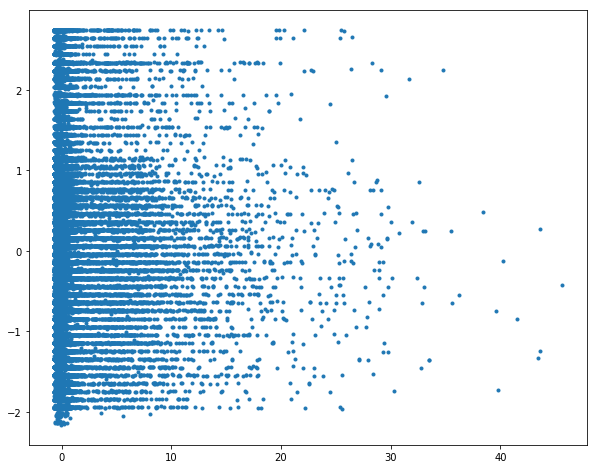

In [344]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(pca_x[:, 0], pca_x[:, 1], '.')

In [345]:
len(pca_x)

294588

In [350]:
#Kmeans
# choose best K (i.e., number of clusters)
inertias = []
silhouettes = []

ks = range(2,16)
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_x)
    
    inertias.append(kmeans.inertia_)
    #silhouettes.append(silhouette_score(pca_x, kmeans.predict(pca_x)))

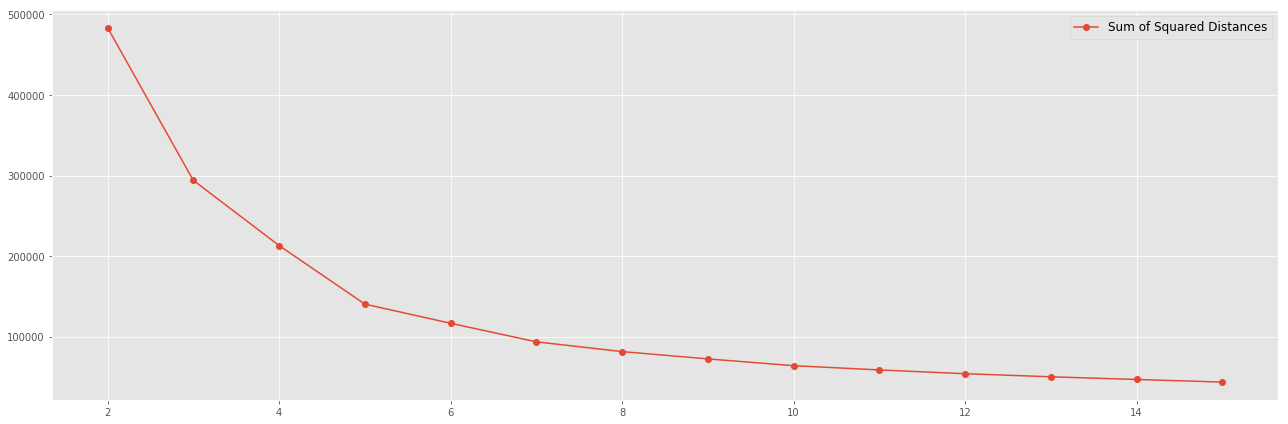

In [425]:
clusters = range(2, 16)
# visualization
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax.grid(True)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
#6 cluster looks the best

In [352]:
#5 cluster looks good, let's have a try
kmeans = KMeans(n_clusters=6)
kmeans.fit(pca_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [355]:
x2d= pd.DataFrame(pca_x, columns=['pca1', 'pca2'])
x2d ['label']=kmeans.labels_

In [356]:
x2d.head()

,pca1,pca2,label
0,-0.426301,1.932596,2
1,-0.140451,0.160346,4
2,-0.402471,-1.452614,3
3,0.032828,-0.346414,4
4,-0.285935,-1.650209,3


In [359]:
x2d['label'].value_counts()
#cluster 5 looks unique
#Let's take a closer look

4    148982
3    102321
2     37646
0      3966
1      1332
5       341
Name: label, dtype: int64

In [362]:
susppicious_label = x2d.label.value_counts().argmin()

/Users/pg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


In [381]:
suspect = transactions.loc[x2d.label == susppicious_label,:]
suspect.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
1220,1087468642191606,2015-08-25 18:37:49,850.83,-121.735805,47.446516
1223,1087468642191606,2015-09-25 21:34:13,941.49,-121.775082,47.362240
2529,1126571863414211,2015-08-05 23:18:45,973.85,-80.262542,40.256228
2591,1126571863414211,2015-09-11 01:33:04,996.17,-80.168257,40.313138
2793,1126571863414211,2015-08-03 18:45:45,990.85,-80.291488,40.274117


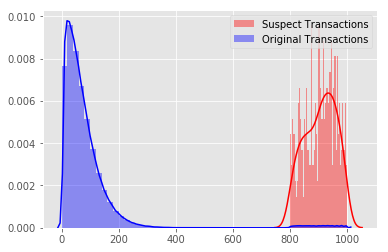

In [423]:
fig, ax = plt.subplots()
#plt.style.use('ggplot')
sns.distplot(suspect['transaction_dollar_amount'].values,  bins=50, label = 'Suspect Transactions', color = 'red')
sns.distplot(transactions['transaction_dollar_amount'].values, bins=50,label = 'Original Transactions', color = 'blue')
plt.legend(loc = 1)

**Apparently the suspect transaction has extraordinarily high amount**